In [81]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [82]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader


%matplotlib inline

In [83]:
#Compose is used to combined different transformations. Monrmalise will normalize the ranges to -1 to +1. (x-mean)/std

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [84]:
img, label = mnist[0]

print('label:', label)
# print(img)
print(img.shape)
print(torch.min(img),torch.max(img))


label: 5
torch.Size([1, 28, 28])
tensor(-1.) tensor(1.)


In [85]:
#a function to denormalize the image

def denorm(img):
    out = (img + 1)/2
    return out.clamp(0,1)

5


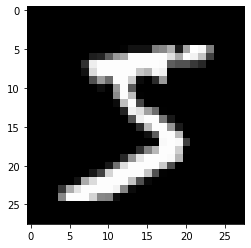

In [86]:
img_norm = denorm(img)
plt.imshow(img_norm[0],cmap='gray')
print(label)

In [87]:

batch_size = 100

dataloader = DataLoader(mnist,batch_size,shuffle=True)


In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Discriminator Network[](http://)**

In [89]:
image_size = 784 #28*28
hidden_size = 256

D = nn.Sequential(
    nn.Linear(image_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),    
    nn.Linear(hidden_size,1),
    nn.Sigmoid())

In [90]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

**Define Generator Network**

In [91]:
latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh())


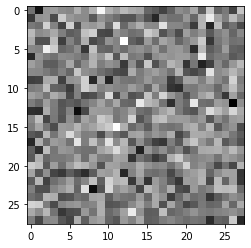

In [92]:
# testing G with a random sample a 2 rows of data

y = G(torch.randn(2,latent_size))

gimg = denorm(y.reshape(-1,28,28).detach())

plt.imshow(gimg[0],cmap='gray')


In [93]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

**Train Discriminator**

In [94]:
learning_rate = 0.0002

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr=learning_rate)


In [95]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
def train_discriminator(images):
    fake_labels = torch.zeros(batch_size,1).to(device)
    real_labels = torch.ones(batch_size,1).to(device)
    
    
    #find real loss
    
    d_real_out = D(images)
    d_real_loss = criterion(d_real_out,real_labels)
    
    #find fake_loss
    z = torch.randn(batch_size,latent_size).to(device)
    fake_images = G(z)
    d_fake_out = D(fake_images)
    d_fake_loss = criterion(d_fake_out,fake_labels)
    
    
    d_loss = d_real_loss + d_fake_loss
    
    reset_grad()
    
    d_loss.backward()
    
    d_optimizer.step()
    
    
    return d_loss, d_real_out, d_fake_out
    
       

Train the generator

In [96]:
g_optimizer = torch.optim.Adam(G.parameters(),learning_rate)

In [97]:
def train_generator():
    
    x = torch.randn(batch_size,latent_size).to(device)
    
    fake_images = G(x)
    labels = torch.ones(batch_size,1).to(device)
    
    g_loss = criterion(D(fake_images),labels)
    
    reset_grad()
    g_loss.backward()
    
    g_optimizer.step()
    
    return g_loss, fake_images
        

In [98]:
# creates a Samples directory

import os

sample_dir = 'samples'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
else:
    print("directory already exists")
    

directory already exists


torch.Size([100, 1, 28, 28])


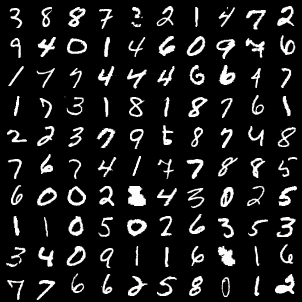

In [99]:
#save a real image
from IPython.display import Image
from torchvision.utils import save_image

#save the first batch of images

for images,_ in dataloader:
    print(images.shape)
    images = images.reshape(images.size(0),1,28,28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
    
Image(os.path.join(sample_dir, 'real_images.png'))



Saving fake_images-0000.png


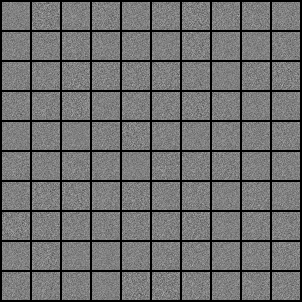

In [100]:
#save generator output images after each epoch, passing the same sample latent vector

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [101]:
#training loop

num_epochs = 300
total_step = len(dataloader)

d_losses, g_losses, real_scores, fake_scores = [],[],[],[]

for epoch in range(num_epochs):
    
    for i, (img,_) in enumerate(dataloader):
        
        img = img.reshape(batch_size,-1).to(device)
        
        d_loss,real_score, fake_score = train_discriminator(img)
        
        g_loss,fake_img = train_generator()
        
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
# Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0489, g_loss: 4.3199, D(x): 0.99, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.4109, g_loss: 3.7939, D(x): 0.85, D(G(z)): 0.11
Epoch [0/300], Step [600/600], d_loss: 0.0734, g_loss: 4.7000, D(x): 0.97, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0734, g_loss: 4.0030, D(x): 0.99, D(G(z)): 0.06
Epoch [1/300], Step [400/600], d_loss: 0.8258, g_loss: 3.2744, D(x): 0.90, D(G(z)): 0.43
Epoch [1/300], Step [600/600], d_loss: 0.5215, g_loss: 3.7314, D(x): 0.86, D(G(z)): 0.24
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3803, g_loss: 3.4842, D(x): 0.93, D(G(z)): 0.22
Epoch [2/300], Step [400/600], d_loss: 1.0290, g_loss: 1.4969, D(x): 0.75, D(G(z)): 0.32
Epoch [2/300], Step [600/600], d_loss: 0.1066, g_loss: 5.2917, D(x): 0.96, D(G(z)): 0.05
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.5489, g_loss: 3.0313, D(x): 0.57, D(G(z)): 0.31
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.2754, g_loss: 2.9554, D(x): 0.91, D(G(z)): 0.07
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.1928, g_loss: 4.2266, D(x): 0.94, D(G(z)): 0.06
Epoch [28/300], Step [400/600], d_loss: 0.3372, g_loss: 3.0015, D(x): 0.92, D(G(z)): 0.12
Epoch [28/300], Step [600/600], d_loss: 0.4601, g_loss: 2.7105, D(x): 0.91, D(G(z)): 0.18
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.4687, g_loss: 3.7335, D(x): 0.91, D(G(z)): 0.19
Epoch [29/300], Step [400/600], d_loss: 0.3197, g_loss: 3.2303, D(x): 0.91, D(G(z)): 0.12
Epoch [29/300], Step [600/600], d_loss: 0.4511, g_loss: 2.9089, D(x): 0.90, D(G(z)): 0.15
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.3801, g_loss: 4.5533, D(x): 0.86, D(G(z)): 0.07
Epoch [30/300], Step [400/600], d_loss: 0.2448, g_loss: 3.1586, D(x): 0.96, D(G(z)): 0.14
Epoch [30/300], Step [600/600], d_loss: 0.3485, g_loss: 4.3424, D(x): 0.87, D(G(z)): 0.08
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.4000, g_loss: 2.7511, D(x): 0.87, D(G(z)): 0.14
Epoch [55/300], Step [600/600], d_loss: 0.6428, g_loss: 2.4698, D(x): 0.83, D(G(z)): 0.22
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.4195, g_loss: 3.0949, D(x): 0.87, D(G(z)): 0.16
Epoch [56/300], Step [400/600], d_loss: 0.3922, g_loss: 3.1013, D(x): 0.86, D(G(z)): 0.12
Epoch [56/300], Step [600/600], d_loss: 0.8148, g_loss: 2.9319, D(x): 0.78, D(G(z)): 0.25
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.4953, g_loss: 2.5690, D(x): 0.87, D(G(z)): 0.20
Epoch [57/300], Step [400/600], d_loss: 0.4530, g_loss: 2.9776, D(x): 0.83, D(G(z)): 0.17
Epoch [57/300], Step [600/600], d_loss: 0.6925, g_loss: 2.2029, D(x): 0.76, D(G(z)): 0.20
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6593, g_loss: 2.5555, D(x): 0.82, D(G(z)): 0.23
Epoch [58/300], Step [400/600], d_loss: 0.6546, g_loss: 1.7860, D(x): 0.86, D(G(z)): 0.26
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.5616, g_loss: 2.6721, D(x): 0.87, D(G(z)): 0.25
Epoch [83/300], Step [400/600], d_loss: 0.5947, g_loss: 2.3112, D(x): 0.80, D(G(z)): 0.21
Epoch [83/300], Step [600/600], d_loss: 0.8109, g_loss: 1.9711, D(x): 0.71, D(G(z)): 0.23
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.9060, g_loss: 2.2533, D(x): 0.88, D(G(z)): 0.42
Epoch [84/300], Step [400/600], d_loss: 0.7714, g_loss: 1.7088, D(x): 0.82, D(G(z)): 0.32
Epoch [84/300], Step [600/600], d_loss: 0.6132, g_loss: 1.9324, D(x): 0.81, D(G(z)): 0.26
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.7454, g_loss: 2.5559, D(x): 0.73, D(G(z)): 0.23
Epoch [85/300], Step [400/600], d_loss: 0.8211, g_loss: 2.0173, D(x): 0.79, D(G(z)): 0.30
Epoch [85/300], Step [600/600], d_loss: 0.9207, g_loss: 2.3755, D(x): 0.70, D(G(z)): 0.23
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.6992, g_loss: 2.3864, D(x): 0.77, D(G(z)): 0.22
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.8317, g_loss: 2.3197, D(x): 0.69, D(G(z)): 0.20
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.9783, g_loss: 1.6445, D(x): 0.73, D(G(z)): 0.36
Epoch [111/300], Step [400/600], d_loss: 0.9516, g_loss: 1.5177, D(x): 0.72, D(G(z)): 0.33
Epoch [111/300], Step [600/600], d_loss: 0.8399, g_loss: 1.6516, D(x): 0.72, D(G(z)): 0.29
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.7512, g_loss: 1.8799, D(x): 0.74, D(G(z)): 0.24
Epoch [112/300], Step [400/600], d_loss: 0.7467, g_loss: 1.4631, D(x): 0.77, D(G(z)): 0.29
Epoch [112/300], Step [600/600], d_loss: 0.8478, g_loss: 1.7181, D(x): 0.72, D(G(z)): 0.27
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.6837, g_loss: 1.7600, D(x): 0.79, D(G(z)): 0.27
Epoch [113/300], Step [400/600], d_loss: 0.7547, g_loss: 1.5870, D(x): 0.76, D(G(z)): 0.27
Epoch [113/300], Step [600/600], d_loss: 0.8378, g_loss: 2.0671, D(x): 0.73, D(G(z)): 0.25
Saving

Epoch [138/300], Step [200/600], d_loss: 0.8038, g_loss: 2.1624, D(x): 0.66, D(G(z)): 0.19
Epoch [138/300], Step [400/600], d_loss: 0.8856, g_loss: 1.4413, D(x): 0.71, D(G(z)): 0.33
Epoch [138/300], Step [600/600], d_loss: 0.8069, g_loss: 1.7139, D(x): 0.77, D(G(z)): 0.30
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.8555, g_loss: 1.7838, D(x): 0.74, D(G(z)): 0.32
Epoch [139/300], Step [400/600], d_loss: 0.8964, g_loss: 1.4566, D(x): 0.70, D(G(z)): 0.28
Epoch [139/300], Step [600/600], d_loss: 0.7542, g_loss: 1.5162, D(x): 0.73, D(G(z)): 0.25
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.9793, g_loss: 1.6065, D(x): 0.70, D(G(z)): 0.34
Epoch [140/300], Step [400/600], d_loss: 0.7735, g_loss: 1.5369, D(x): 0.73, D(G(z)): 0.27
Epoch [140/300], Step [600/600], d_loss: 0.9619, g_loss: 1.6124, D(x): 0.68, D(G(z)): 0.31
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.9386, g_loss: 2.2126, D(x): 0.64, D(G(z)): 0.23
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.7661, g_loss: 1.6777, D(x): 0.75, D(G(z)): 0.28
Epoch [165/300], Step [600/600], d_loss: 0.8166, g_loss: 1.6475, D(x): 0.70, D(G(z)): 0.26
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.9306, g_loss: 1.3603, D(x): 0.72, D(G(z)): 0.34
Epoch [166/300], Step [400/600], d_loss: 1.0582, g_loss: 1.4463, D(x): 0.61, D(G(z)): 0.29
Epoch [166/300], Step [600/600], d_loss: 0.7828, g_loss: 1.4261, D(x): 0.73, D(G(z)): 0.29
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.8676, g_loss: 1.1630, D(x): 0.79, D(G(z)): 0.38
Epoch [167/300], Step [400/600], d_loss: 0.7762, g_loss: 1.7697, D(x): 0.81, D(G(z)): 0.35
Epoch [167/300], Step [600/600], d_loss: 0.9154, g_loss: 1.1242, D(x): 0.71, D(G(z)): 0.36
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.9988, g_loss: 1.4040, D(x): 0.67, D(G(z)): 0.34
Epoch [168/300], Step [400/600], d_loss: 0.8840, g_loss: 1.7398, D(x): 0.68, D(G(z)): 0.28
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.8429, g_loss: 1.3011, D(x): 0.71, D(G(z)): 0.29
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.9778, g_loss: 1.7834, D(x): 0.66, D(G(z)): 0.30
Epoch [193/300], Step [400/600], d_loss: 0.8370, g_loss: 1.6210, D(x): 0.71, D(G(z)): 0.29
Epoch [193/300], Step [600/600], d_loss: 0.8831, g_loss: 1.8693, D(x): 0.67, D(G(z)): 0.26
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.9817, g_loss: 1.3985, D(x): 0.63, D(G(z)): 0.29
Epoch [194/300], Step [400/600], d_loss: 0.9347, g_loss: 1.6809, D(x): 0.64, D(G(z)): 0.26
Epoch [194/300], Step [600/600], d_loss: 1.0162, g_loss: 1.2230, D(x): 0.67, D(G(z)): 0.31
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.9169, g_loss: 1.6437, D(x): 0.73, D(G(z)): 0.35
Epoch [195/300], Step [400/600], d_loss: 0.8824, g_loss: 1.4984, D(x): 0.72, D(G(z)): 0.31
Epoch [195/300], Step [600/600], d_loss: 1.0369, g_loss: 1.6309, D(x): 0.61, D(G(z)): 0.29
Saving

Epoch [220/300], Step [200/600], d_loss: 0.8702, g_loss: 1.4717, D(x): 0.74, D(G(z)): 0.34
Epoch [220/300], Step [400/600], d_loss: 1.0316, g_loss: 1.5896, D(x): 0.65, D(G(z)): 0.32
Epoch [220/300], Step [600/600], d_loss: 1.0465, g_loss: 1.3216, D(x): 0.67, D(G(z)): 0.33
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.9583, g_loss: 1.7252, D(x): 0.69, D(G(z)): 0.33
Epoch [221/300], Step [400/600], d_loss: 0.8886, g_loss: 1.3884, D(x): 0.75, D(G(z)): 0.36
Epoch [221/300], Step [600/600], d_loss: 0.9965, g_loss: 1.6442, D(x): 0.70, D(G(z)): 0.33
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.9169, g_loss: 1.2627, D(x): 0.74, D(G(z)): 0.36
Epoch [222/300], Step [400/600], d_loss: 1.1121, g_loss: 1.4126, D(x): 0.63, D(G(z)): 0.32
Epoch [222/300], Step [600/600], d_loss: 0.8136, g_loss: 1.4227, D(x): 0.74, D(G(z)): 0.29
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.9782, g_loss: 1.7957, D(x): 0.72, D(G(z)): 0.37
Epoch 

Epoch [247/300], Step [400/600], d_loss: 1.0270, g_loss: 1.5229, D(x): 0.75, D(G(z)): 0.41
Epoch [247/300], Step [600/600], d_loss: 0.9784, g_loss: 1.8155, D(x): 0.63, D(G(z)): 0.28
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 1.0727, g_loss: 1.3042, D(x): 0.67, D(G(z)): 0.33
Epoch [248/300], Step [400/600], d_loss: 0.8758, g_loss: 1.4110, D(x): 0.67, D(G(z)): 0.27
Epoch [248/300], Step [600/600], d_loss: 0.9518, g_loss: 1.5304, D(x): 0.74, D(G(z)): 0.39
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 1.1444, g_loss: 1.6618, D(x): 0.64, D(G(z)): 0.35
Epoch [249/300], Step [400/600], d_loss: 1.0421, g_loss: 1.2284, D(x): 0.65, D(G(z)): 0.32
Epoch [249/300], Step [600/600], d_loss: 1.0826, g_loss: 1.2795, D(x): 0.72, D(G(z)): 0.41
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.8986, g_loss: 1.2473, D(x): 0.69, D(G(z)): 0.30
Epoch [250/300], Step [400/600], d_loss: 0.9840, g_loss: 1.3206, D(x): 0.69, D(G(z)): 0.33
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.9655, g_loss: 1.4759, D(x): 0.71, D(G(z)): 0.37
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 1.0279, g_loss: 1.6181, D(x): 0.65, D(G(z)): 0.31
Epoch [275/300], Step [400/600], d_loss: 0.8815, g_loss: 1.2416, D(x): 0.71, D(G(z)): 0.32
Epoch [275/300], Step [600/600], d_loss: 0.9172, g_loss: 1.4829, D(x): 0.70, D(G(z)): 0.33
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.8560, g_loss: 1.5608, D(x): 0.67, D(G(z)): 0.26
Epoch [276/300], Step [400/600], d_loss: 1.0179, g_loss: 1.5146, D(x): 0.70, D(G(z)): 0.37
Epoch [276/300], Step [600/600], d_loss: 1.1899, g_loss: 1.4967, D(x): 0.55, D(G(z)): 0.28
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.9926, g_loss: 1.3862, D(x): 0.66, D(G(z)): 0.33
Epoch [277/300], Step [400/600], d_loss: 0.8775, g_loss: 1.5314, D(x): 0.67, D(G(z)): 0.27
Epoch [277/300], Step [600/600], d_loss: 0.9250, g_loss: 1.3023, D(x): 0.72, D(G(z)): 0.36
Saving

In [102]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

FileNotFoundError: No such file or directory: './samples/fake_images-0125.png'

FileNotFoundError: No such file or directory: './samples/fake_images-0125.png'

<IPython.core.display.Image object>

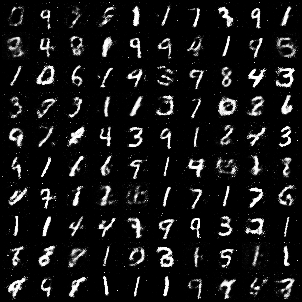

In [103]:
#see the images

Image('./samples/fake_images-0125.png')

In [104]:
#### combine the images to a video

import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/kaggle/working/gans_training.avi

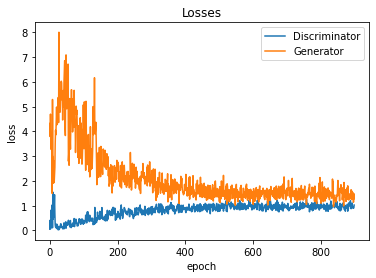

In [105]:
#plot the losses

plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');




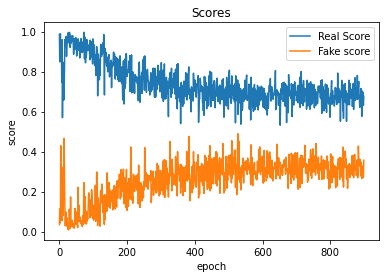

In [106]:
# plot the scores

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');